In [399]:
#UNI: yh3506
#load the packages:
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
#load the data:
PUBG_data = pd.read_csv("PUBG_data.csv")

In [400]:
print("The number of rows in the original dataset is " + str(len(PUBG_data)))

The number of rows in the original dataset is 4446966


In [401]:
#check the missing value situation:
PUBG_data.isnull().sum().to_frame('nulls')

,nulls
Id,0
groupId,0
matchId,0
assists,0
boosts,0
damageDealt,0
DBNOs,0
headshotKills,0
heals,0
killPlace,0


We can see that there is only one missing in the winPlacePerce, and hence it won't affect the distribution of data by removing it.

In [402]:
PUBG_data = PUBG_data.dropna()

In [403]:
PUBG_data.shape

(4446965, 29)

(array([621846., 485258., 461998., 410339., 385639., 423227., 376146.,
        385841., 427440., 469231.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

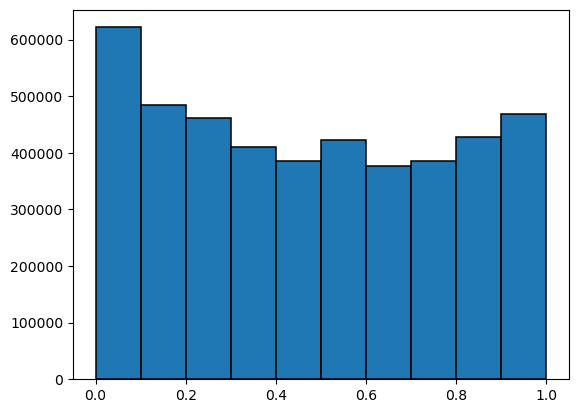

In [404]:
#check whether the distribution of traget variable is balanced or imbalanced:
plt.hist(PUBG_data["winPlacePerc"], edgecolor='black', linewidth=1.1)

In [405]:
#we can see that it's roughly balanced for the training dataset
#hence, we can randomly select a subset from it:
PUBG_data_subset = PUBG_data.sample(n=4446966//100, random_state=100)
PUBG_data_subset.shape

(44469, 29)

(array([6340., 4837., 4561., 4127., 3868., 4153., 3700., 3873., 4342.,
        4668.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

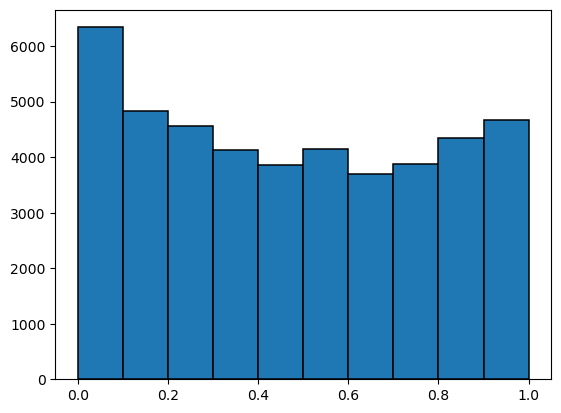

In [406]:
#check the distribution again
plt.hist(PUBG_data_subset["winPlacePerc"], edgecolor='black', linewidth=1.1)
#based on the plot below, the random sample gives a similar distribution:

<AxesSubplot:>

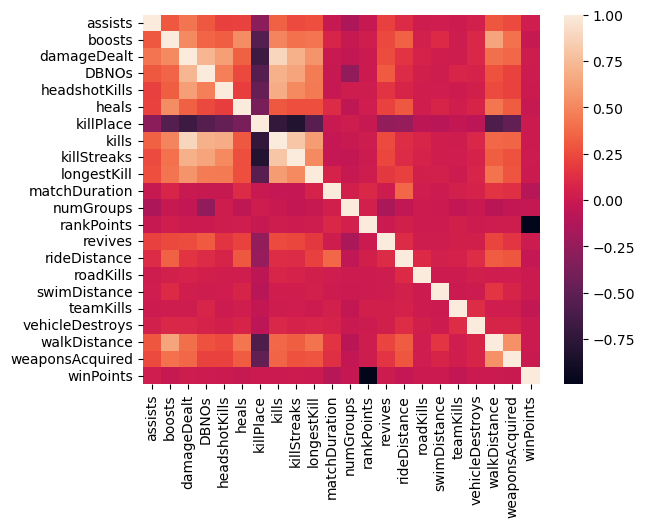

In [407]:
sb.heatmap(train_data_subset.corr())

In [408]:
#killPoints - Kills-based external ranking of player.
PUBG_data_subset = PUBG_data_subset.drop(['killPoints','maxPlace'],axis = 1)
PUBG_data        = PUBG_data.drop(['killPoints','maxPlace'],axis = 1)
#drop all useless string data type:
PUBG_data_subset = PUBG_data_subset.drop(["Id", "groupId", "matchId", "matchType"],axis=1)
PUBG_data        = PUBG_data.drop(["Id", "groupId", "matchId", "matchType"],axis=1)

In [409]:
#making the training data and test dataset:
X_subset = PUBG_data_subset
#winPlacePerc
y_subset = X_subset.pop("winPlacePerc")
X_dev, X_test, y_dev, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

In [410]:
#implement the model:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(26681, 22)
(26681,)
(8894, 22)
(8894,)
(8894, 22)
(8894,)


In [411]:
#using the lgb.LGBMRegressor:
clf = lgb.LGBMRegressor(random_state=0)

In [412]:
start = time.time()

clf.fit(X_train, y_train)

end = time.time()

# get the execution time
total = end - start
print('The Training time is:', round(total,2), 'seconds')

The Training time is: 0.38 seconds


We can see that LightGBM can finish the training on the sample with a middle size in a short period. Now, we can check the training time on the full dataset which has millions of data and multiple dimensions.

In [413]:
#making the training data and test dataset:
X = PUBG_data
#winPlacePerc
y = X.pop("winPlacePerc")
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

In [414]:
#implement the model:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(2668179, 22)
(2668179,)
(889393, 22)
(889393,)
(889393, 22)
(889393,)


In [415]:
#using the lgb.LGBMRegressor:
clf = lgb.LGBMRegressor(random_state=0)

In [416]:
start = time.time()

clf.fit(X_train, y_train)

end = time.time()

# get the execution time
total = end - start
print('The Training time is:', round(total,2), 'seconds')

The Training time is: 26.04 seconds


Even though the size of data increases by around $100$ times, the training time on large-scale dataset is still reasonably short ($38$ times longer than before). This reflects the advantage of LightGBM: it has a faster training speed due to its distributed high-performance framework.

<h3>Hyperparameter Tuning<h3>

In [417]:
parameters = {  
    "n_estimators":  [100, 300, 500],
    "learning_rate": [0.01, 0.1, 1],
    "num_leaves": [21,31,41]
}

clf_exp = lgb.LGBMRegressor(boosting_type='gbdt',random_state=0)
GSCclf = GridSearchCV(clf_exp, param_grid=parameters, cv=5)
clf_optimal = GSCclf.fit(X_train, y_train)
res = GSCclf.best_params_

In [418]:
print(res)

{'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 31}


In [419]:
#using optimal hyperparameters:
clf = lgb.LGBMRegressor(random_state=0,
                        n_estimators=res['n_estimators'],
                        learning_rate=res['learning_rate'],
                        num_leaves=res['num_leaves'])

In [420]:
clf.fit(X_train, y_train)

LGBMRegressor(n_estimators=300, random_state=0)

In [421]:
y_train_pred = clf.predict(X_train)
#the MSE for training data:
print("The MSE on the training data is",  round(mean_squared_error(y_train_pred,y_train),6))
#the RMSE for training data:
print("The RMSE on the training data is", round(mean_squared_error(y_train_pred,y_train,squared = False),6))
#the MAE for training data:
print("The MAE on the training data is",  round(mean_absolute_error(y_train_pred,y_train),6))

The MSE on the training data is 0.006685
The RMSE on the training data is 0.081764
The MAE on the training data is 0.058451


In [422]:
#check the R^2 score on training data prediction:
print("R^2, the coefficient of determination of the prediction on training data, is ", round(clf.score(X_train,y_train),6))

R^2, the coefficient of determination of the prediction on training data, is  0.929298


In [423]:
y_val_pred = clf.predict(X_val)
#the MSE for validation data:
print("The MSE on the validation data is",  round(mean_squared_error(y_val_pred,y_val),6))
#the RMSE for validation data:
print("The RMSE on the validation data is", round(mean_squared_error(y_val_pred,y_val,squared = False),6))
#the MAE for validation data:
print("The MAE on the validation data is",  round(mean_absolute_error(y_val_pred,y_val),6))

The MSE on the validation data is 0.006774
The RMSE on the validation data is 0.082303
The MAE on the validation data is 0.058665


In [424]:
#check the R^2 score on training data prediction:
print("R^2, the coefficient of determination of the prediction on validation data, is ", round(clf.score(X_val,y_val),6))

R^2, the coefficient of determination of the prediction on validation data, is  0.928265


In [425]:
y_test_pred = clf.predict(X_test)
#the MSE for training data:
print("The MSE on the test data is",  round(mean_squared_error(y_test_pred,y_test),6))
#the RMSE for training data:
print("The RMSE on the test data is", round(mean_squared_error(y_test_pred,y_test,squared = False),6))
#the MAE for training data:
print("The MAE on the test data is",  round(mean_absolute_error(y_test_pred,y_test),6))

The MSE on the test data is 0.006769
The RMSE on the test data is 0.082277
The MAE on the test data is 0.058632


In [426]:
#check the R^2 score on training data prediction:
print("R^2, the coefficient of determination of the prediction on test data, is ", round(clf.score(X_test,y_test),6))

R^2, the coefficient of determination of the prediction on test data, is  0.928284


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

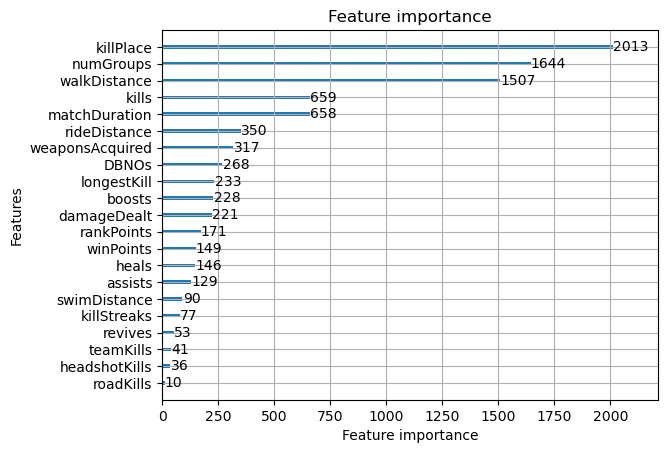

In [427]:
#the freature importance by using LightGBM:
lgb.plot_importance(clf)